## Libraries

In [1]:
mogp_dir <- "/data/rlguensat/conda_envs/envHM/lib/python3.8/site-packages/mogp_emulator"
## important to add "import warning" at MutliOutputGP.py

setwd('..')

source('ExeterUQ_MOGP/BuildEmulator/BuildEmulator.R')
source('ExeterUQ_MOGP/HistoryMatching/HistoryMatching.R')
#source("HistoryMatching/impLayoutplot.R")
source('ExeterUQ_MOGP/BuildEmulator/utils.R')

library(comprehenr)
library(caret, include.only = 'preProcess')
library("future.apply") #important for parallel version of ImplausibilityMOGP function in HistoryMatching.R

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


Attaching package: ‘maps’


The following object is masked from ‘package:viridis’:

    unemp


This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORE

# Read data 

In [2]:
my_bounds <- data.frame(c(0, 2), c(1, 20), c(1, 20))

In [3]:
set.seed(42)
inputs <- as.data.frame(2*maximinLHS(30, 3)-1)
inputs_unscaled <- rangeUnscale(inputs, my_bounds)
names(inputs) <- c('h','c','b')
names(inputs_unscaled) <- c('h','c','b')
inputs_unscaled

h,c,b
<dbl>,<dbl>,<dbl>
1.12691832,14.622326,4.093787
0.49848666,11.459464,11.226994
1.67111857,10.983653,11.967675
1.51465860,3.702973,10.931057
0.68479527,16.002236,16.378997
0.42177202,12.119893,4.435670
0.55900331,5.706285,5.108778
1.28871397,7.245246,17.619563
1.53990535,8.037390,13.261429


In [4]:
write.csv(inputs_unscaled,"Data/df_inputs_newPCA_PhysPrior_AMIP_wave1.csv", row.names = FALSE)

In [6]:
set.seed(42)
                       
#Load outputs and select variables you want to keep
outputs <- read.csv("Data/df_metrics_newPCA_PhysPrior_AMIP_classic_wave1.csv")
                         
#Add some noise (here no noise added)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,c,b,Noise,pca_0,pca_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1269183,0.43392910,-0.6743383,0.68547922,6.4754678,1.820781291
2,-0.5015133,0.10099621,0.0765257,-0.28234909,-4.5725060,-0.666303500
3,0.6711186,0.05091089,0.1544921,0.18156421,-2.4317714,0.007813257
4,0.5146586,-0.71547657,0.0453744,0.31643130,-2.1780007,0.152277467
5,-0.3152047,0.57918273,0.6188418,0.20213416,-5.0777198,-1.067552813
6,-0.5782280,0.17051504,-0.6383505,-0.05306226,-0.7868835,1.584495662


### Training Emulators

In [7]:
#choices.new <- choices.default
#choices.new$lm.maxdf = 3 ### NOT WORKING
#choices.new$lm.tryFouriers=TRUE  ### NOT WORKING

In [8]:
TestEm <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:3])  #important to put this line
                            #Choices = lapply(1:length(outputs), function(k) choices.new))

[1] "Max reduction is 2.14432316470109 using b"
[1] "Max reduction is 1.14345700676654 using b"
[1] "Max reduction is 1.32070309052097 using h"
[1] "Max reduction is 0.903566507861184 using b"
[1] "Max reduction is 0.91261194709791 using Three Way Interactions with b"
[1] "Max reduction is 0.399001029045792 using b"
[1] "Max reduction is 0.12514603775183 using c"
[1] "Max reduction is 0.18166495616042 using h"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ b + I(b^2) + I(b^3) + I(b^4) + h + I(h^2) + 
    c + I(h * b) + I(c * b) + I(c * h) + I(b * h * b) + I(b * 
    c * b) + I(b * c * h), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6617 -0.5030  0.1278  0.7425  1.2705 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -2.3593     0.6497  -3.632  0.00224 ** 
b             -1.2708     1.0539  -1.206  0.24542    
I(b^2)         1.0804     3.2264   0.335  0.74208    
I(b^3)       -18.5182     1.6700 -11.089 6.40

In [10]:
tDisc <- rep(0, length(outputs))
tObs <- read.csv("Data/df_obs_nonoise_newPCA_PhysPrior_AMIP_classic_wave1.csv")
tObs <- as.vector(t(tObs))
tObsErr <- rep(0, length(outputs))

## LOO

In [11]:
cands <- names(tData)[1:3]

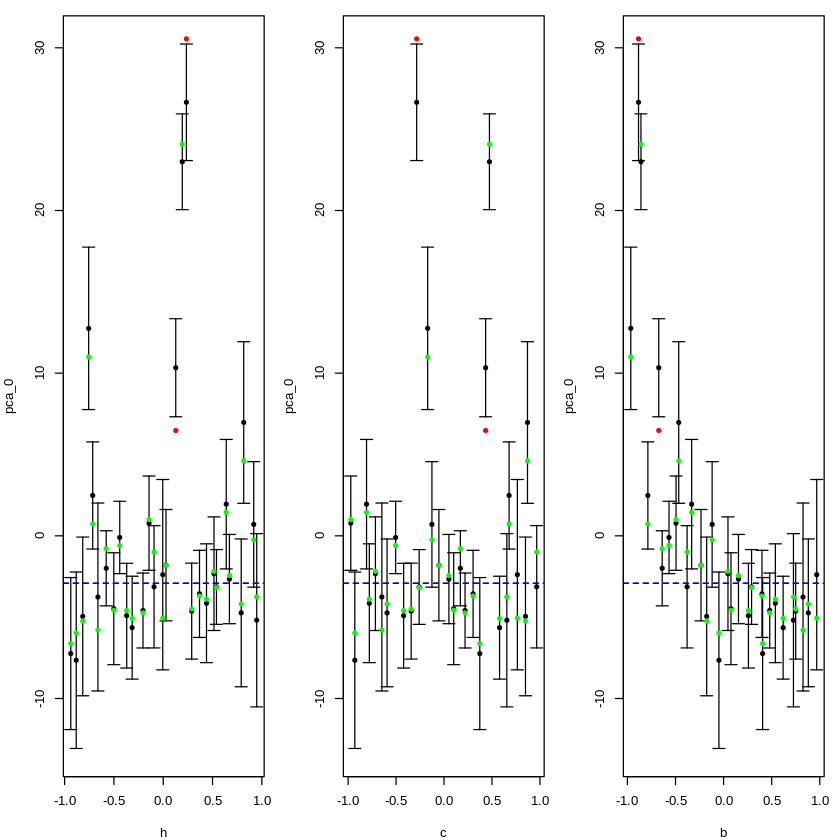

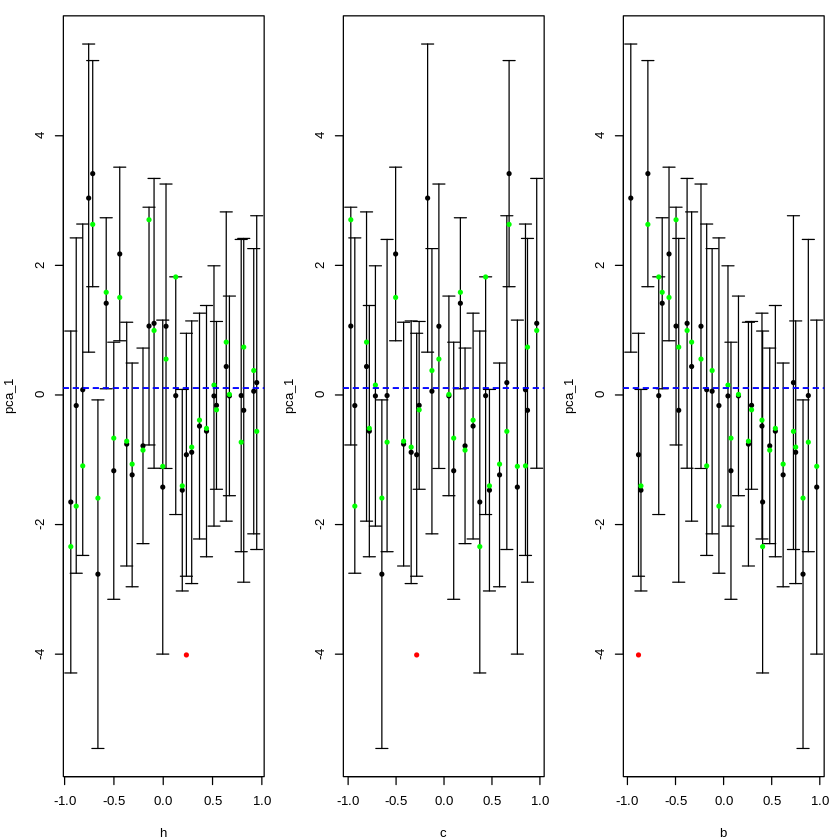

In [12]:
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 1, ParamNames = cands, Obs = tObs[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm, which.emulator = 2, ParamNames = cands, Obs = tObs[2], ObsErr = 0.)#tLOOs <- 

## History Matching
* Observations discrepancy variances in *tDisc* (here sets to 0)
* Observations errors in *tObsErr* (here set to 0)

In [13]:
future::availableCores() 

system 
    48

In [14]:
set.seed(42)
sample_size <- 1000000
nparam <- length(names(TestEm$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(TestEm$fitting.elements$Design)

In [15]:
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  2.887   5.038   3.843 

In [16]:
ImpData_wave1 = cbind(Xp, Timps)
print(object.size(ImpData_wave1), units="Mb")

38.1 Mb


In [17]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off?
cutoff_vec <- 3 #the implausibility cut off

param.def = data.frame(h=c(1), c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

  h           c           b
1 0 -0.05263158 -0.05263158


In [18]:
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=TestEm$mogp$n_emulators, whichMax=valmax+1)
NROY1 <- which(rowSums(Timps <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
ratio1 <- length(NROY1)/dim(Xp)[1]
ratio1

[1] 0.718623

#### 30 samples for training, 1 000 000 points for test

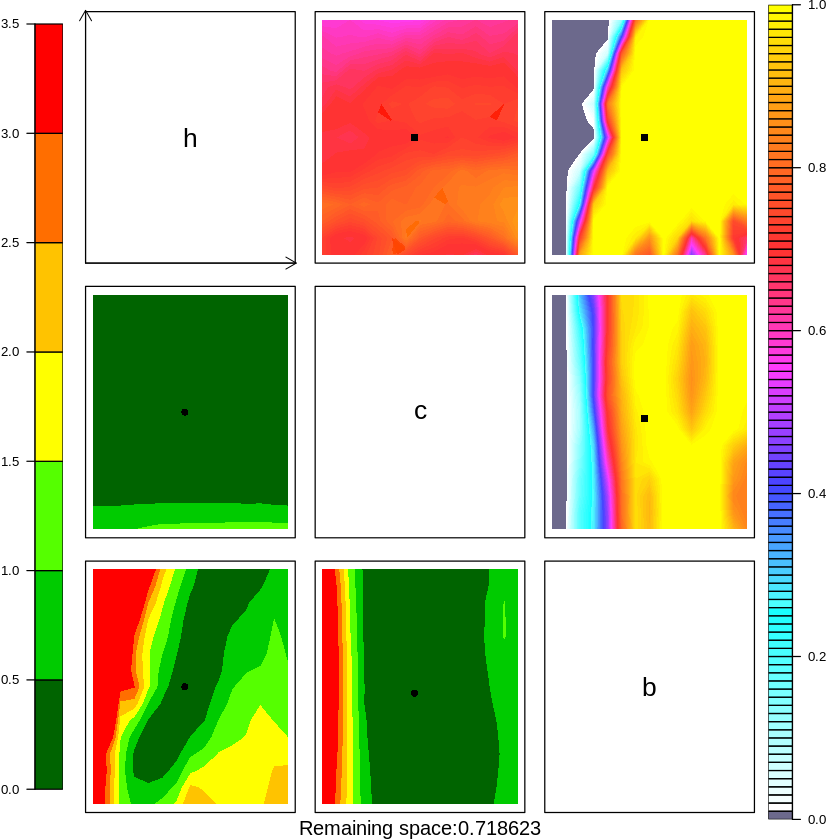

In [19]:
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY1)/dim(Xp)[1],sep=""), side=1)

In [20]:
length(NROY1)

[1] 718623

# Wave2

In [21]:
30/ratio1

[1] 41.74651

In [22]:
set.seed(42)

designpoints <- data.frame()

while (nrow(designpoints) <= 30) {
        tmp <- as.data.frame(2*maximinLHS(ceil(30/ratio1), 3)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        selectionP <- tmp[NROYtmp,]
        row.names(selectionP) <- NULL ## to avoid double index
        designpoints <- rbind(designpoints,selectionP)
        print(nrow(designpoints))
        flush.console()
        } 

designpoints <- designpoints[sample(nrow(designpoints),30),]

designpoints_denorm <- rangeUnscale(designpoints, my_bounds)

[1] 29
[1] 60


In [23]:
designpoints_denorm

,h,c,b
,<dbl>,<dbl>,<dbl>
33,1.275415872,5.541792,17.622751
24,1.141046152,7.356102,18.083747
27,0.133208417,14.898465,4.475619
3,0.797379441,1.942921,15.641419
2,1.355008462,5.678204,14.719824
23,0.145232692,16.344855,17.485690
39,0.350378084,6.825035,7.373392
29,0.048969539,2.433802,13.990902
59,0.057544025,19.998789,13.040747


In [24]:
write.csv(designpoints_denorm,"Data/exp_TuningL94_newPCA_PhysPrior_AMIP_classic_wave2.csv", row.names = FALSE)

In [25]:
inputs <- designpoints

#Load outputs and select variables you want to keep
outputs <- read.csv("Data/df_metrics_newPCA_PhysPrior_AMIP_classic_wave2.csv")
                         
#Add some noise (here no noise added)
set.seed(42)

N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,c,b,Noise,pca_0,pca_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
33,0.2754159,-0.5219166,0.7497633,0.68547922,-4.502127,-0.8026659
24,0.1410462,-0.3309366,0.7982892,-0.28234909,-4.727988,-0.9152851
27,-0.8667916,0.4629963,-0.6341453,0.18156421,-4.383367,-0.3980900
3,-0.2026206,-0.9007452,0.5412020,0.31643130,-4.623381,-0.7043859
2,0.3550085,-0.5075574,0.4441920,0.20213416,-3.822032,-0.4480675
23,-0.8547673,0.6152479,0.7353358,-0.05306226,-6.295295,-2.0377858


In [26]:
TestEm2 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:3])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.313594020099968 using h"
[1] "Max reduction is 0.814200082402131 using b"
[1] "Max reduction is 0.121646532919969 using b"
[1] "Max reduction is 0.121167969596444 using Three Way Interactions with b"
[1] "Max reduction is 0.0711671298569601 using c"
[1] "Max reduction is 0.0626371765211708 using h"
[1] "Max reduction is 0.0455730675483596 using Three Way Interactions with h"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ h + I(h^2) + b + I(b^2) + c + I(b * h) + 
    I(c * h) + I(c * b) + I(b * b * h) + I(b * c * h) + I(b * 
    c * b) + I(h * b * h) + I(h * c * h), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31647 -0.12368 -0.04933  0.09809  0.39990 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -2.58755    0.10527 -24.580 3.90e-14 ***
h             2.38094    0.21370  11.142 5.98e-09 ***
I(h^2)       -1.75461    0.39147  -4.482 0.000377 ***
b            -5.15697    0.22688 -2

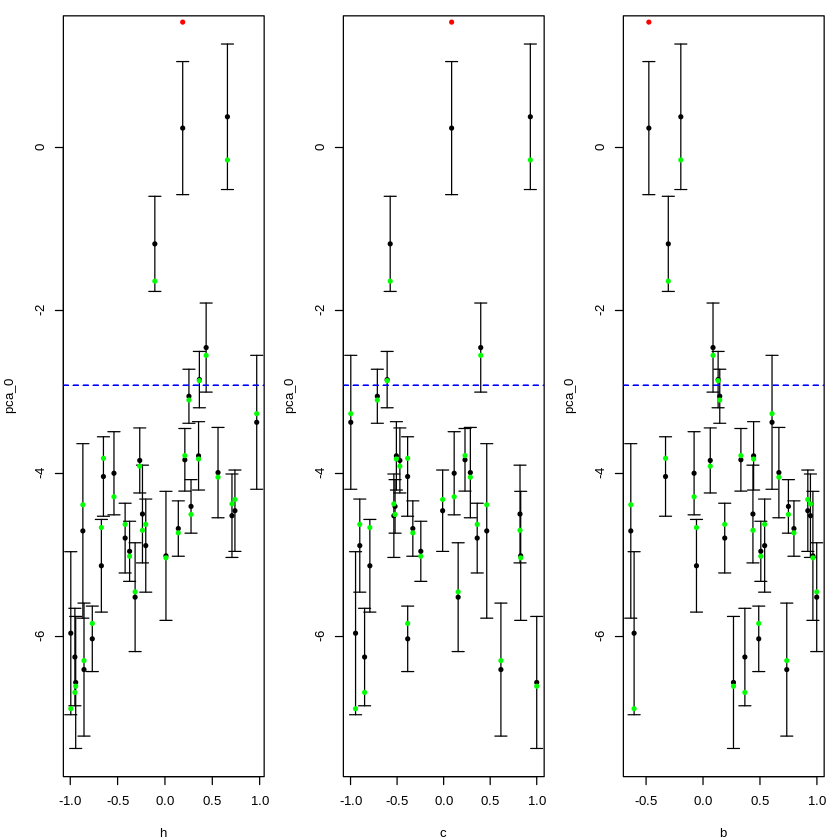

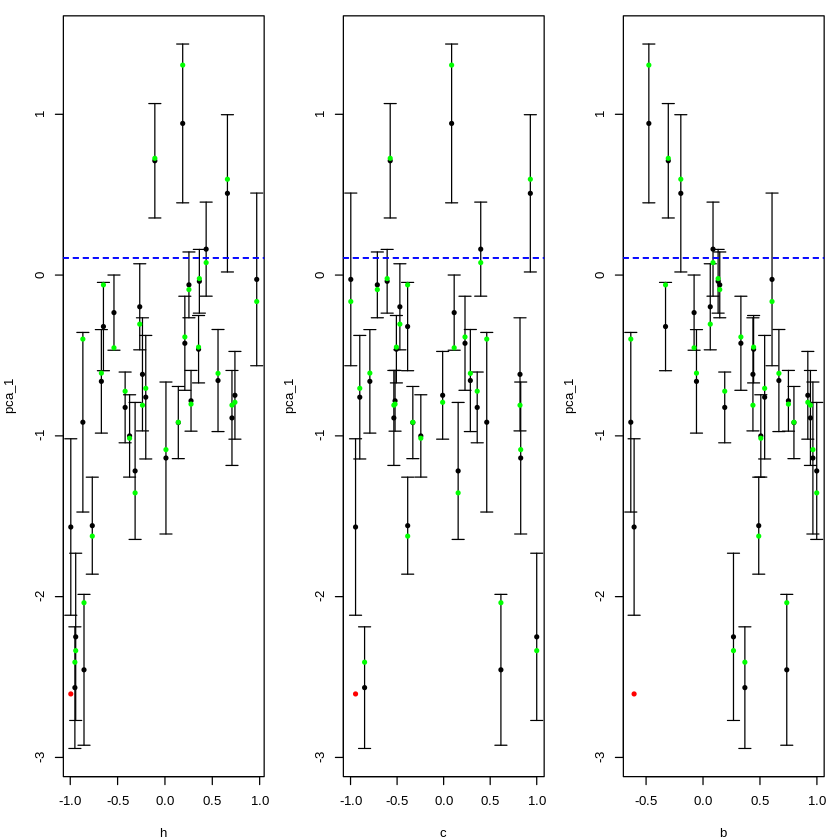

In [27]:
cands <- names(tData)[1:3]
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 1, ParamNames = cands, Obs = tObs[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm2, which.emulator = 2, ParamNames = cands, Obs = tObs[2], ObsErr = 0.)#tLOOs <- 

In [28]:
Timps2 <- matrix(rep(t(Timps),1), ncol=ncol(Timps), byrow=TRUE)
system.time(Timps2[NROY1,] <- ImplausibilityMOGP(NewData=Xp[NROY1,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  2.209  37.830   5.326 

In [29]:
#tracemem(Timps2) == tracemem(Timps)

In [30]:
ImpData_wave2 = cbind(Xp, Timps2)

In [31]:
valmax2 = 0 #how many outputs can be above the implausibility cut off?
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=TestEm2$mogp$n_emulators, whichMax=valmax2+1)
NROY2 <- which(rowSums(Timps2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax2)
ratio2 <- length(NROY2)/dim(Xp)[1]
ratio2

[1] 0.121854

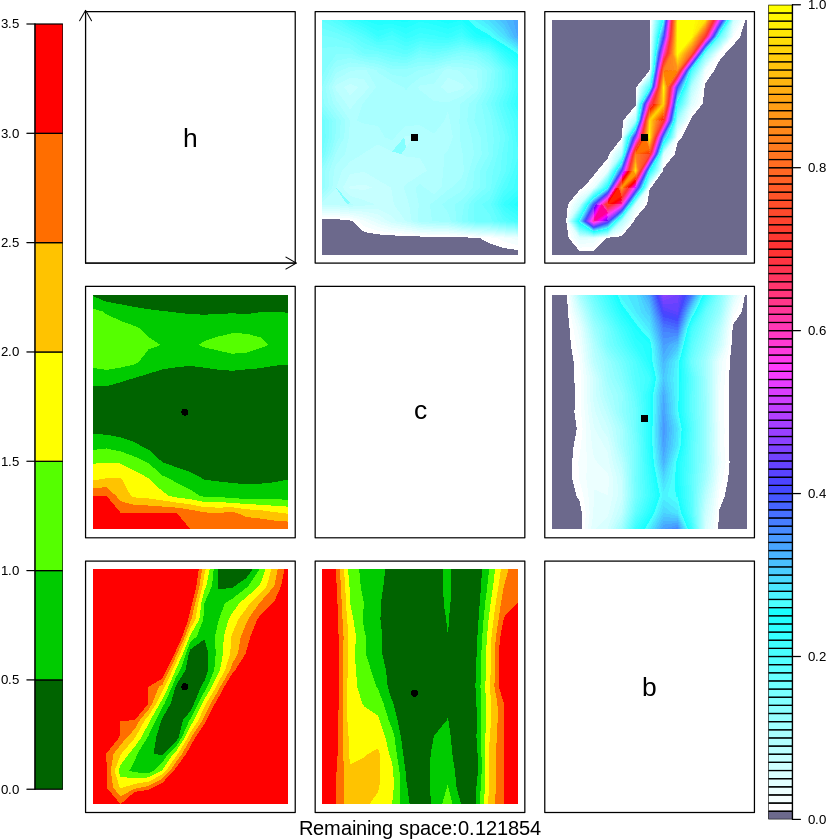

In [32]:
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY2)/dim(Xp)[1],sep=""), side=1)

In [33]:
length(NROY2)

[1] 121854

# Wave 3

In [34]:
30/ratio2

[1] 246.1963

In [35]:
set.seed(42)

designpoints2 <- data.frame()

while (nrow(designpoints2) <= 30) { 
        ### Emulator wave 1
        tmp <- as.data.frame(2*maximinLHS(ceil(30/ratio2), 3)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints2 <- rbind(designpoints2,selectionP)
        print(nrow(designpoints2))
        flush.console()
        } 

designpoints2 <- designpoints2[sample(nrow(designpoints2),30),]

designpoints_denorm2 <- rangeUnscale(designpoints2, my_bounds)

[1] 31


In [36]:
designpoints_denorm2

,h,c,b
,<dbl>,<dbl>,<dbl>
2,0.4934398,6.924438,6.976206
26,1.2028495,19.404072,13.255798
19,1.3273711,9.393972,11.822652
12,1.0405641,16.521057,10.548068
18,1.5897703,16.737751,13.004470
28,1.7613760,19.886023,13.686422
13,0.2721807,14.778766,5.668102
27,1.3013565,3.103845,11.370930
24,1.7524707,1.361919,13.189475


In [37]:
write.csv(designpoints_denorm2,"Data/exp_TuningL94_newPCA_PhysPrior_AMIP_classic_wave3.csv", row.names = FALSE)

In [38]:
inputs <- designpoints2

#Load outputs and select variables you want to keep
outputs <- read.csv('Data/df_metrics_newPCA_PhysPrior_AMIP_classic_wave3.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,c,b,Noise,pca_0,pca_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,-0.50656025,-0.3763750,-0.370925662,0.68547922,-2.883143,0.42547137
26,0.20284948,0.9372707,0.290083998,-0.28234909,-3.644546,-0.30408247
19,0.32737108,-0.1164240,0.139226536,0.18156421,-2.990573,-0.06316681
12,0.04056415,0.6337955,0.005059823,0.31643130,-3.025080,0.05660192
18,0.58977026,0.6566054,0.263628385,0.20213416,-2.949578,-0.13204939
28,0.76137599,0.9880024,0.335412860,-0.05306226,-2.925993,-0.18132376


In [39]:
TestEm3 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:3])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.027096406536888 using c"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ c, data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.65773 -0.31096  0.00041  0.21104  0.86740 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.97490    0.07353 -40.457   <2e-16 ***
c           -0.27122    0.11943  -2.271    0.031 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3911 on 28 degrees of freedom
Multiple R-squared:  0.1555,	Adjusted R-squared:  0.1254 
F-statistic: 5.158 on 1 and 28 DF,  p-value: 0.03103

[1] "Max reduction is 0.118927931967135 using b"
[1] "Max reduction is 0.0317216917153111 using h"
[1] "Max reduction is 0.0339278166930311 using h"
[1] "Max reduction is 0.0110006609180109 using h"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_1 ~ b + h + I(h^2) + I(h^3) + I(h * b), data = tData)

Residuals:
     Min       1Q   Medi

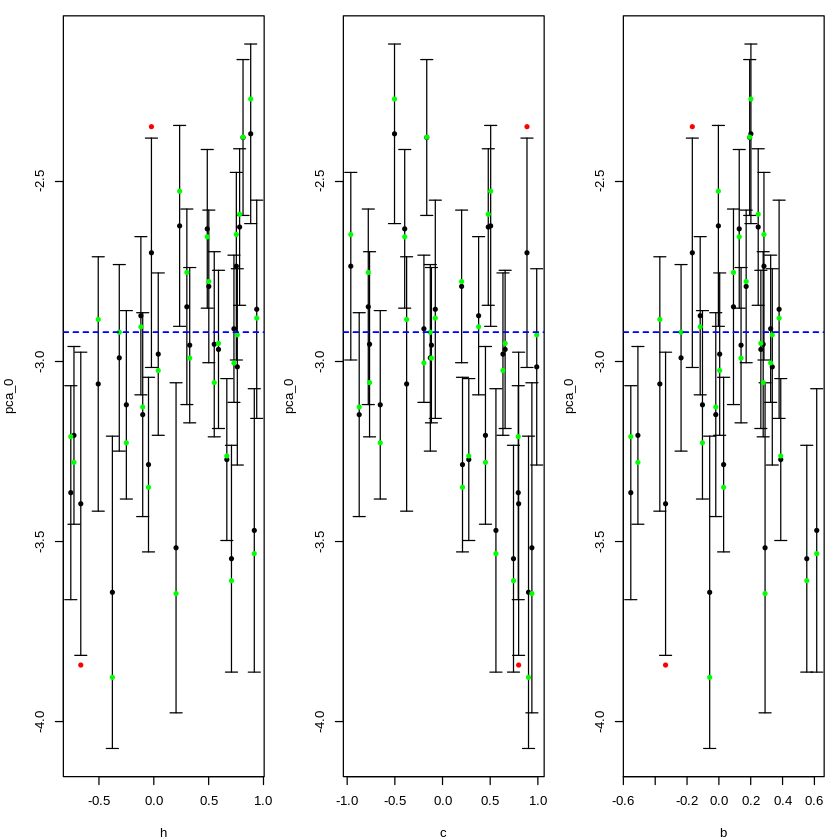

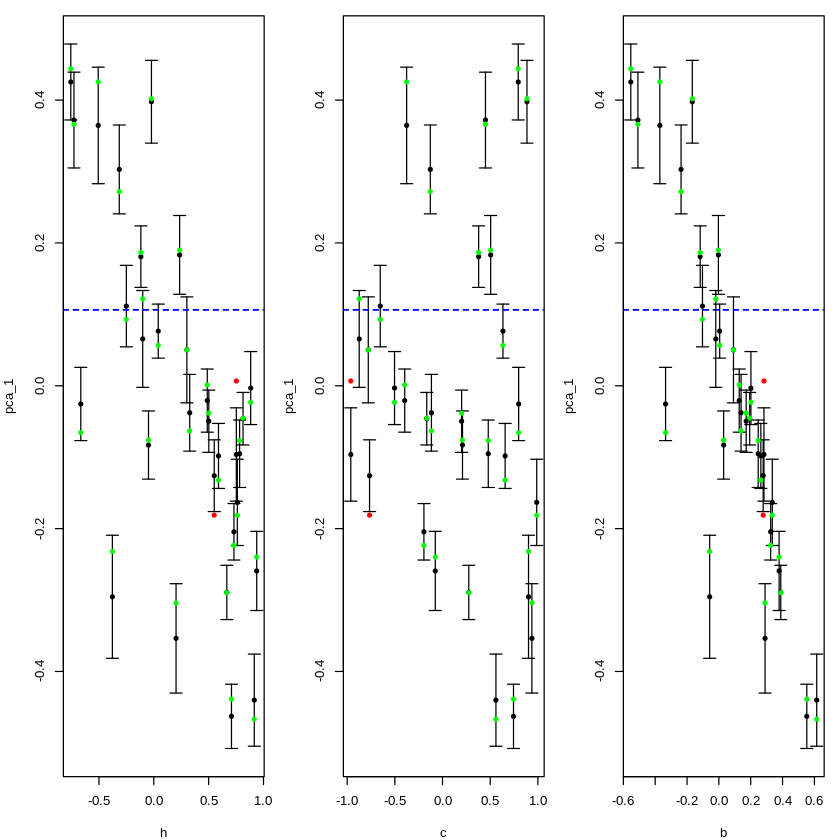

In [40]:
cands <- names(tData)[1:3]
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 1, ParamNames = cands, Obs = tObs[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm3, which.emulator = 2, ParamNames = cands, Obs = tObs[2], ObsErr = 0.)#tLOOs <- 

In [41]:
Timps3 <- matrix(rep(t(Timps2),1), ncol=ncol(Timps2), byrow=TRUE)
system.time(Timps3[NROY2,] <- ImplausibilityMOGP(NewData=Xp[NROY2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  0.407  50.366   2.547 

In [42]:
ImpData_wave3 = cbind(Xp, Timps3)

In [43]:
valmax3 = 0 #how many outputs can be above the implausibility cut off?
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=TestEm3$mogp$n_emulators, whichMax=valmax3+1)
NROY3 <- which(rowSums(Timps3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax3)
ratio3 <- length(NROY3)/dim(Xp)[1]
ratio3

[1] 0.012358

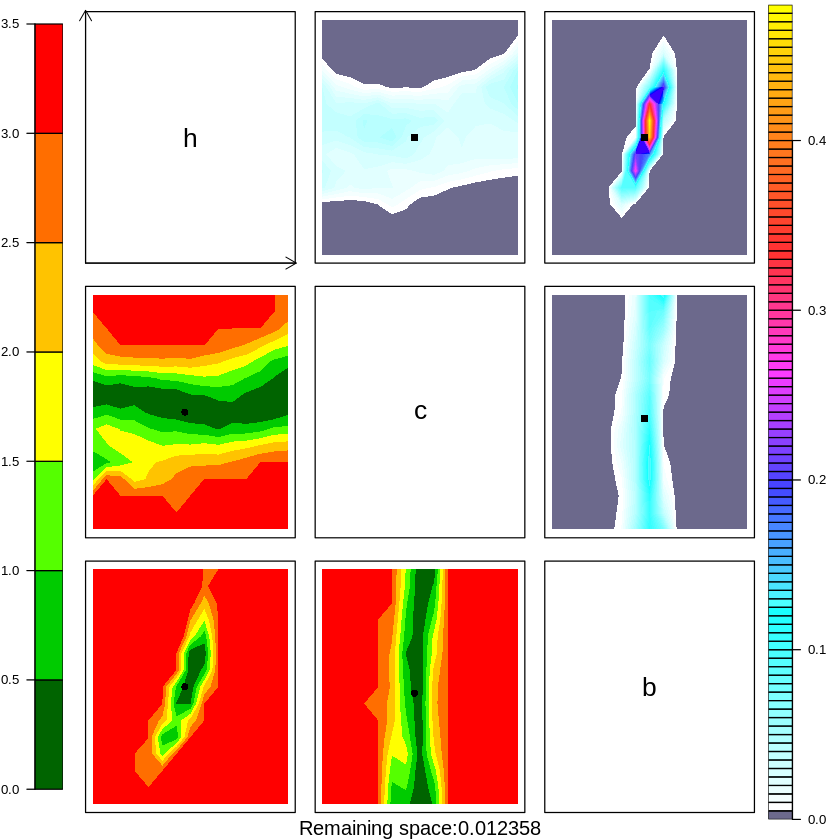

In [44]:
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY3)/dim(Xp)[1],sep=""), side=1)

In [45]:
length(NROY3)

[1] 12358

## wave 4

In [46]:
30/ratio3

[1] 2427.577

In [47]:
set.seed(42)

designpoints3 <- data.frame()

while (nrow(designpoints3) <= 30) { 
        ### Emulator wave 1
        tmp <- as.data.frame(2*maximinLHS(ceil(30/ratio3), 3)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        ### Emulator wave 3
        imps_tmp3 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp3 <- which(rowSums(imps_tmp3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,][NROYtmp3,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints3 <- rbind(designpoints3,selectionP)
        print(nrow(designpoints3))
        flush.console()
        } 

designpoints3 <- designpoints3[sample(nrow(designpoints3),30),]

designpoints_denorm3 <- rangeUnscale(designpoints3, my_bounds)

[1] 35


In [48]:
write.csv(designpoints_denorm3,"Data/exp_TuningL94_newPCA_PhysPrior_AMIP_classic_wave4.csv", row.names = FALSE)

In [49]:
designpoints3

,h,c,b
,<dbl>,<dbl>,<dbl>
28,0.452849495,0.88976773,0.049265225
35,-0.161514483,-0.43296343,-0.096571007
22,-0.249383705,-0.59000982,-0.117791130
14,0.258007999,0.92436693,0.106811920
31,0.025430717,-0.31068746,-0.011022752
21,-0.192215735,-0.84654392,-0.087711942
33,0.261757450,0.70401213,0.058076370
24,-0.038259364,-0.15030596,-0.042950765
18,-0.383824922,-0.95688802,-0.143442010


In [51]:
inputs <- designpoints3

#Load outputs and select variables you want to keep
outputs <- read.csv('Data/df_metrics_newPCA_PhysPrior_AMIP_classic_wave4.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,c,b,Noise,pca_0,pca_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,0.45284949,0.8897677,0.04926523,0.68547922,-2.317476,0.159263210
35,-0.16151448,-0.4329634,-0.09657101,-0.28234909,-3.067387,0.125931295
22,-0.24938371,-0.5900098,-0.11779113,0.18156421,-3.190935,0.098761591
14,0.25800800,0.9243669,0.10681192,0.31643130,-2.947100,0.002780163
31,0.02543072,-0.3106875,-0.01102275,0.20213416,-3.015628,0.049983755
21,-0.19221574,-0.8465439,-0.08771194,-0.05306226,-3.051137,0.212065725


In [52]:
TestEm4 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:3])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.134279659840915 using h"
[1] "Max reduction is 0.0168442215187122 using b"
[1] "Max reduction is 0.0207846092682631 using c"
[1] "Max reduction is 0.0135241446896209 using c"
[1] "Max reduction is 0.021287241815234 using Three Way Interactions with c"
[1] "Noise fitted, stopping algorithm"

Call:
lm(formula = pca_0 ~ h + b + c + I(c^2) + I(b * h) + I(c * h) + 
    I(c * b) + I(c * b * h) + I(c * c * h) + I(c * c * b), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.091114 -0.022171  0.003657  0.018713  0.145178 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  -3.18859    0.02955 -107.907  < 2e-16 ***
h             2.85336    0.27007   10.565 2.16e-09 ***
b            -5.25975    0.70407   -7.470 4.56e-07 ***
c            -0.07528    0.02584   -2.913 0.008914 ** 
I(c^2)        0.27590    0.05632    4.899 9.96e-05 ***
I(b * h)     -1.63306    0.70771   -2.308 0.032447 *  
I(c * h)      0.59770    0

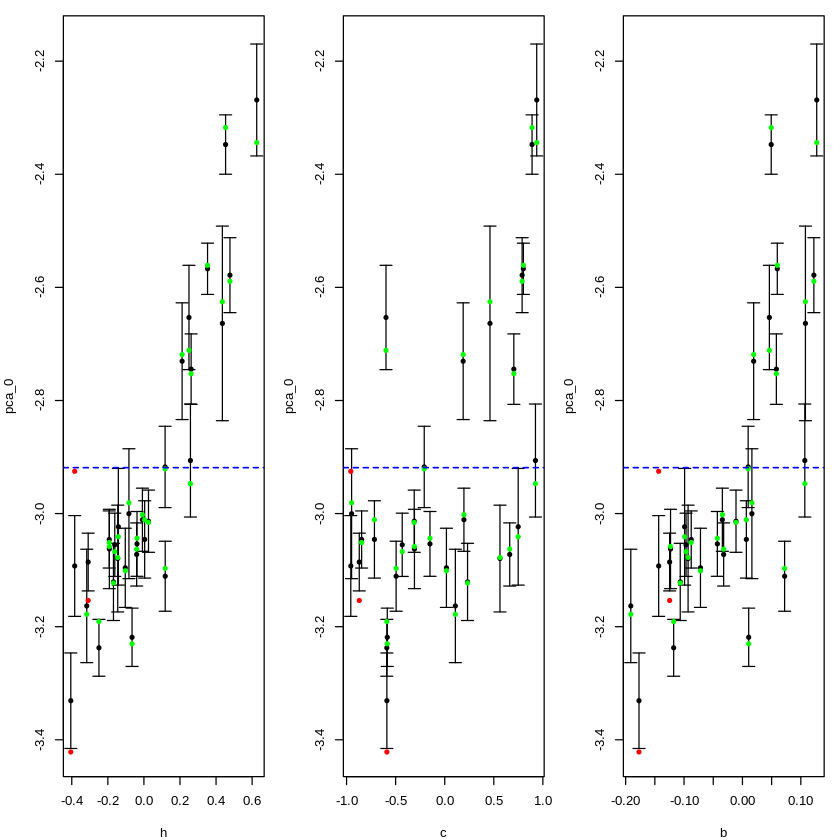

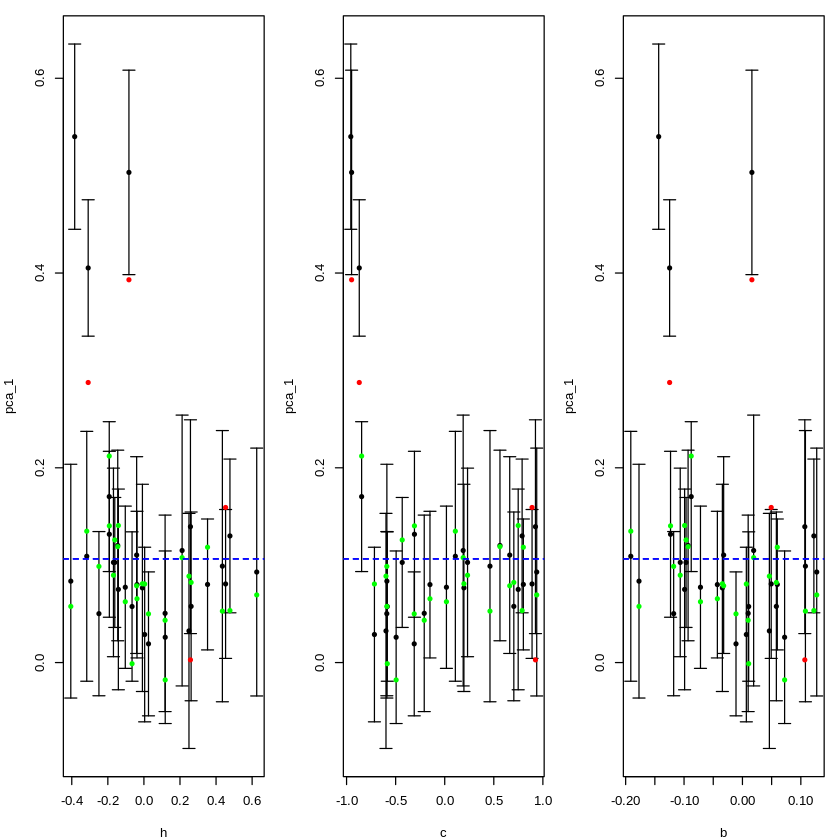

In [53]:
cands <- names(tData)[1:3]
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 1, ParamNames = cands, Obs = tObs[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm4, which.emulator = 2, ParamNames = cands, Obs = tObs[2], ObsErr = 0.)#tLOOs <- 

In [54]:
Timps4 <- matrix(rep(t(Timps3),1), ncol=ncol(Timps3), byrow=TRUE)
system.time(Timps4[NROY3,] <- ImplausibilityMOGP(NewData=Xp[NROY3,], Emulator=TestEm4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  0.113  50.677   3.364 

In [55]:
ImpData_wave4 = cbind(Xp, Timps4)

#### It is safe here to use a cut off value of 2 

In [56]:
valmax4 = 0 #how many outputs can be above the implausibility cut off?
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=TestEm4$mogp$n_emulators, whichMax=valmax4+1)
NROY4 <- which(rowSums(Timps4 <= 2) >= TestEm4$mogp$n_emulators -valmax4)
ratio4 <- length(NROY4)/dim(Xp)[1]
ratio4

[1] 0.001247

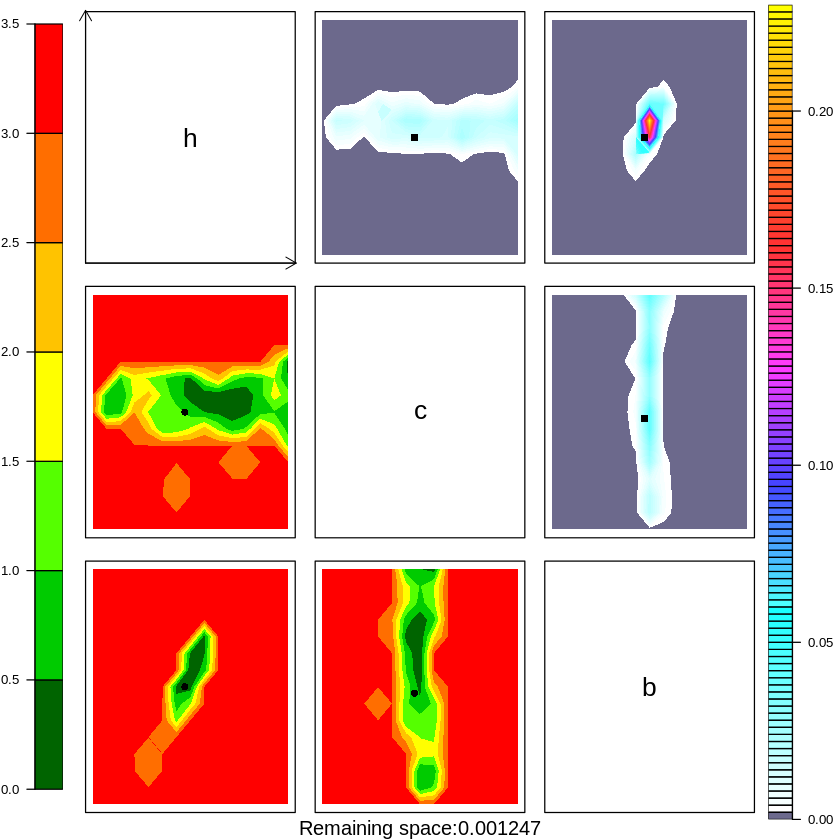

In [57]:
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY4)/dim(Xp)[1],sep=""), side=1)

In [58]:
length(NROY4)

[1] 1247

## wave 5

In [59]:
30/ratio4 

[1] 24057.74

switch to randomLHS

In [60]:
set.seed(42)

designpoints4 <- data.frame()

while (nrow(designpoints4) <= 30) {
        ### Emulator wave 1
        tmp <- as.data.frame(2*randomLHS(ceil(30/ratio4), 3)-1)
        names(tmp) <- names(TestEm$fitting.elements$Design)
        imps_tmp <- ImplausibilityMOGP(NewData=tmp, Emulator=TestEm, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp <- which(rowSums(imps_tmp <= cutoff_vec[1]) >= TestEm$mogp$n_emulators -valmax)
        ### Emulator wave 2
        imps_tmp2 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,], Emulator=TestEm2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp2 <- which(rowSums(imps_tmp2 <= cutoff_vec[1]) >= TestEm2$mogp$n_emulators -valmax)
        ### Emulator wave 3
        imps_tmp3 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,], Emulator=TestEm3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp3 <- which(rowSums(imps_tmp3 <= cutoff_vec[1]) >= TestEm3$mogp$n_emulators -valmax)
        ### Emulator wave 4
        imps_tmp4 <- ImplausibilityMOGP(NewData=tmp[NROYtmp,][NROYtmp2,][NROYtmp3,], Emulator=TestEm4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROYtmp4 <- which(rowSums(imps_tmp4 <= cutoff_vec[1]) >= TestEm4$mogp$n_emulators -valmax)
        #####
        selectionP <- tmp[NROYtmp,][NROYtmp2,][NROYtmp3,][NROYtmp4,]
        row.names(selectionP) <- NULL ## to avoid double index   
        designpoints4 <- rbind(designpoints4,selectionP)
        print(nrow(designpoints4))
        flush.console()
        } 

designpoints4 <- designpoints4[sample(nrow(designpoints4),30),]

designpoints_denorm4 <- rangeUnscale(designpoints4, my_bounds)

[1] 67


In [61]:
write.csv(designpoints_denorm4,"Data/exp_TuningL94_newPCA_PhysPrior_AMIP_classic_wave5.csv", row.names = FALSE)

In [63]:
inputs <- designpoints4

#Load outputs and select variables you want to keep
outputs <- read.csv('Data/df_metrics_newPCA_PhysPrior_AMIP_classic_wave5.csv')
                         
set.seed(42)
N = nrow(inputs) #nb samples 
noise <- rnorm(N, 0, 0.5)
tData <- cbind(inputs, noise, outputs)
names(tData)[names(tData) == "noise"] <- "Noise"
                         
head(tData)

,h,c,b,Noise,pca_0,pca_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
66,0.10733712,0.08186226,-0.013646547,0.68547922,-2.818301,0.10942728
67,0.10001557,0.19876091,-0.002897186,-0.28234909,-2.889953,0.08145475
41,0.22900235,0.79270830,0.072134593,0.18156421,-2.866968,0.05076645
28,0.03222539,0.90144338,-0.010064098,0.31643130,-2.962297,0.09942956
52,0.09942879,0.37451079,0.013653561,0.20213416,-2.926865,0.07625910
37,0.09113646,-0.04780852,-0.024410834,-0.05306226,-2.822776,0.10790560


In [64]:
TestEm5 <- BuildNewEmulators(tData,
                            HowManyEmulators = length(outputs),
                            meanFun = "fitted",
                            #kernel = c("Matern52"),
                            additionalVariables = names(tData)[1:3])  #important to put this line

                            #Choices = lapply(1:length(outputs),
                            #                   function(k) choices.new),

[1] "Max reduction is 0.00717164207140253 using h"
[1] "Max reduction is 0.0498182827898873 using b"
[1] "Max reduction is 0.00400871409223111 using c"
[1] "Max reduction is 0.00505276874202821 using c"
[1] "Max reduction is 0.00500193498751736 using c"
[1] "Max reduction is 0.00204658125429959 using b"
[1] "Max reduction is 0.000374071459420598 using c"
[1] "Max reduction is 4.08472209441658e-05 using Three Way Interactions with b"
[1] "No permitted terms improve the fit"

Call:
lm(formula = pca_0 ~ h + b + I(b^2) + c + I(c^2) + I(c^3) + I(c^4) + 
    I(b * h) + I(c * h) + I(c * b) + I(b * b * h) + I(b * c * 
    h) + I(b * c * b), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.013113 -0.002508  0.000123  0.002524  0.008748 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  -3.13125    0.00799 -391.914  < 2e-16 ***
h             2.27664    0.06168   36.913  < 2e-16 ***
b            -3.67764    0.11291  -32.570 4.70e-16 

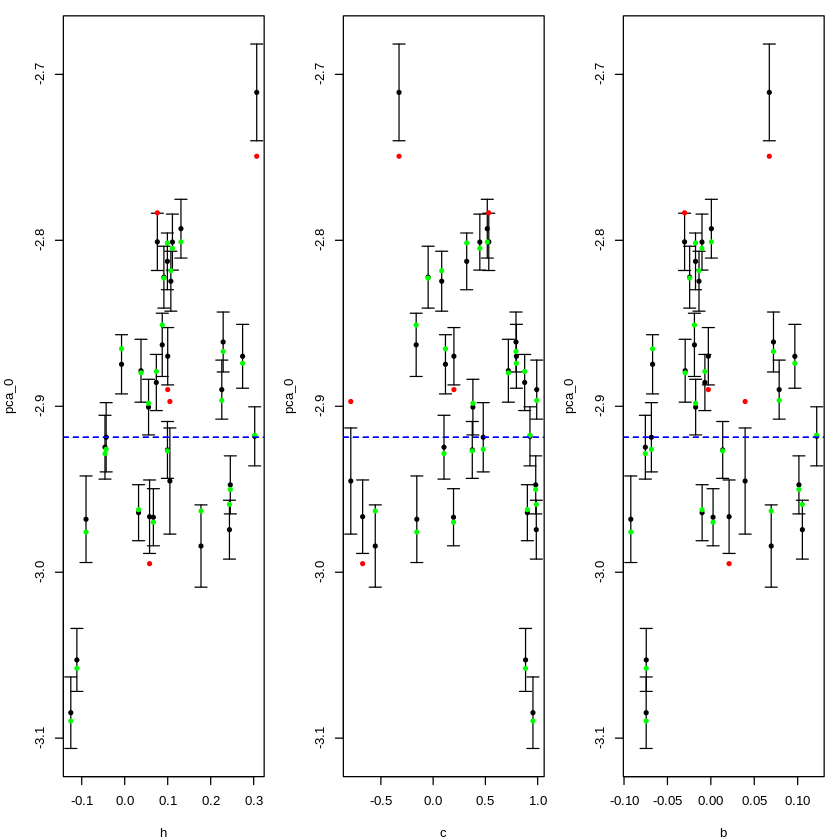

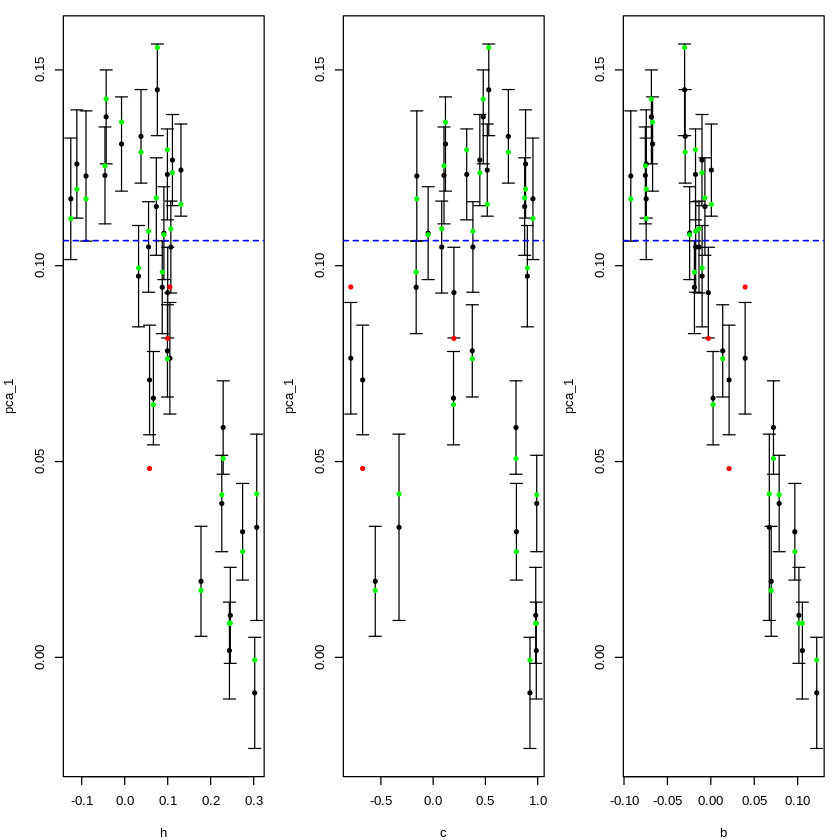

In [65]:
cands <- names(tData)[1:3]
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 1, ParamNames = cands, Obs = tObs[1], ObsErr = 0.)#tLOOs <- 
tLOOs <- LOO.plot(Emulators = TestEm5, which.emulator = 2, ParamNames = cands, Obs = tObs[2], ObsErr = 0.)#tLOOs <- 

In [66]:
Timps5 <- matrix(rep(t(Timps4),1), ncol=ncol(Timps4), byrow=TRUE)
system.time(Timps5[NROY4,] <- ImplausibilityMOGP(NewData=Xp[NROY4,], Emulator=TestEm5, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
  0.095  60.587   3.090 

In [67]:
ImpData_wave5 = cbind(Xp, Timps5)

In [68]:
valmax5 = 0 #how many outputs can be above the implausibility cut off?
ImpListM5 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave5, nEms=TestEm5$mogp$n_emulators, whichMax=valmax4+1)
NROY5 <- which(rowSums(Timps5 <= 2) >= TestEm5$mogp$n_emulators -valmax5)
ratio5 <- length(NROY5)/dim(Xp)[1]
ratio5

[1] 9e-05

In [70]:
png("AMIP_NROY.png", res = 110)
imp.layoutm11(ImpListM5,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY5)/dim(Xp)[1],sep=""), side=1)
dev.off()

png 
  2

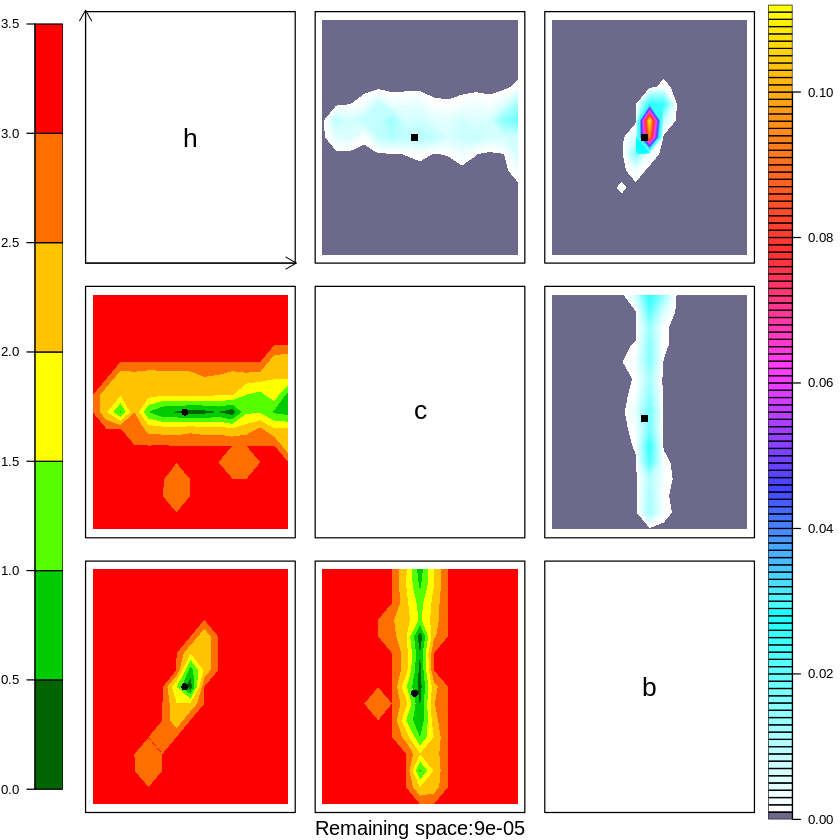

In [69]:
imp.layoutm11(ImpListM5,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",length(NROY5)/dim(Xp)[1],sep=""), side=1)

In [71]:
length(NROY5)

[1] 90

## K-means

In [72]:
library(ClusterR)

Warning message:
“package ‘ClusterR’ was built under R version 3.6.3”Loading required package: gtools
Warning message:
“package ‘gtools’ was built under R version 3.6.3”
Attaching package: ‘gtools’

The following object is masked from ‘package:pracma’:

    logit



In [73]:
preProcValues <- preProcess(Xp[NROY5,], method = c("center", "scale"))
normalizeddata <- predict(preProcValues, Xp[NROY5,])

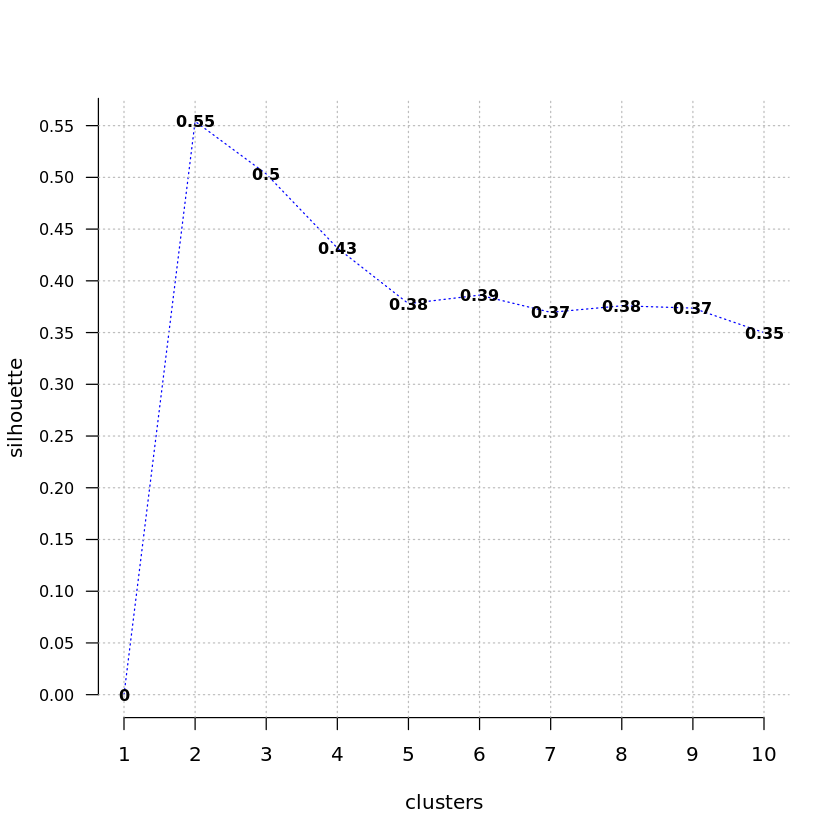

In [74]:
opt_km = Optimal_Clusters_KMeans(normalizeddata, 
                                 criterion = "silhouette", 
                                 max_clusters=10,
                                 plot_clusters = TRUE)

In [75]:
classif <- kmeans(normalizeddata, centers=2, iter.max=100, nstart=100)
kmcenters <- unPreProc(preProcValues, data.frame(classif$centers))
candidates <- rangeUnscale(kmcenters, my_bounds)
candidates

h,c,b
1.000784,10.26192,10.03289
1.054902,16.97905,10.40691


In [76]:
nrow(rangeUnscale(unPreProc(preProcValues, normalizeddata[classif$cluster==2,]), my_bounds))

[1] 35

In [77]:
library(xtable)

print.xtable(xtable(candidates))


Attaching package: ‘xtable’

The following object is masked from ‘package:spam’:

    display



% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Fri Feb 18 11:44:23 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & h & c & b \\ 
  \hline
1 & 1.00 & 10.26 & 10.03 \\ 
  2 & 1.05 & 16.98 & 10.41 \\ 
   \hline
\end{tabular}
\end{table}


# Ensemble of plausible simulations

In [78]:
### check if Kmeans centers are in NROY4
imps_kmeans <- ImplausibilityMOGP(NewData=kmcenters, Emulator=TestEm5, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
which(rowSums(imps_kmeans <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax4)

[1] 1 2

In [79]:
testpoints <- rangeUnscale(kmcenters, my_bounds)[rowSums(imps_kmeans <= cutoff_vec[1]) >= TestEm5$mogp$n_emulators -valmax5,]

In [80]:
testpoints

h,c,b
1.000784,10.26192,10.03289
1.054902,16.97905,10.40691


In [81]:
write.csv(testpoints,"/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/finaltestpoints_newPCA_PhysPrior_classic_AMIP.csv", row.names = FALSE)

## summary of the HM

In [82]:
NROYs <- 100 * c(ratio1, ratio2, ratio3, ratio4, ratio5)
NbSim <- c(30, nrow(designpoints), nrow(designpoints2), nrow(designpoints3), nrow(designpoints4))

In [83]:
data.frame(NROYs, NbSim)

NROYs,NbSim
71.8623,30
12.1854,30
1.2358,30
0.1247,30
0.0090,30


In [84]:
print.xtable(xtable(data.frame(NROYs, NbSim)))

% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Fri Feb 18 11:44:46 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & NROYs & NbSim \\ 
  \hline
1 & 71.86 & 30.00 \\ 
  2 & 12.19 & 30.00 \\ 
  3 & 1.24 & 30.00 \\ 
  4 & 0.12 & 30.00 \\ 
  5 & 0.01 & 30.00 \\ 
   \hline
\end{tabular}
\end{table}


In [85]:
sum(NbSim)

[1] 150